### Objective: To try using the descriptor information from external antibodies to enrich the dataset using semi-supervised learning/transfer learning. 

Cyrus suggested we try using the external data. 


#### Method:
1. Load the data: external antibodies and internal antibodie descriptors from structure. 
2. Try: 
    - PCA on External and then model. 
    - Semi-supervised learning. 
3. Compare. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from shutil import copy
import matplotlib.pyplot as plt
import nglview as nv
from Bio.SeqUtils import seq3
from tqdm.notebook import tqdm
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import numpy as np
import plotly.express as px
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier

from sklearn.metrics import RocCurveDisplay

from developability.utils import ls

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

##### Load the precalculated descriptors. 

In [3]:
BASE_PATH = Path('/Users/ChristopherRivera/Documents/DataResults/')
DATAPATH  = BASE_PATH/ 'MPK190'
EXTERNAL_DATAPATH = BASE_PATH/ 'TherapeuticAntibodies/fv_only_pbds'

descriptors_df = pd.read_parquet(DATAPATH/'MPK190_descriptors_V13_heparin_column.pq')
th_ab_descriptors_df = pd.read_parquet(EXTERNAL_DATAPATH/'solved_ab_descriptors_10-18-2023.pq')

metadata = DATAPATH/'MPK190-v13-metadata.pq'
metadata_df =pd.read_parquet(metadata)
heparin = metadata_df[['Hep RTT']]

##### Split the data as previously on 10-24-2023. 

In [4]:
heparin['Label'] = heparin['Hep RTT']>1.0
X_train, X_test, y_train, y_test = train_test_split(descriptors_df, heparin, shuffle=True, stratify=heparin['Label'], train_size = 60, random_state =42)
distribution = pd.concat([y_train.mean(), y_test.mean()], axis = 1)
distribution.columns = ['Train', 'Test']
distribution

,Train,Test
Hep RTT,0.9974,1.006333
Label,0.4000,0.444444


### Model with PCA
Below, we fit PCA to the data and then use the first X components to train a L1 logistic regression model.

##### Find which columns have lots of zeros to remove for both. 

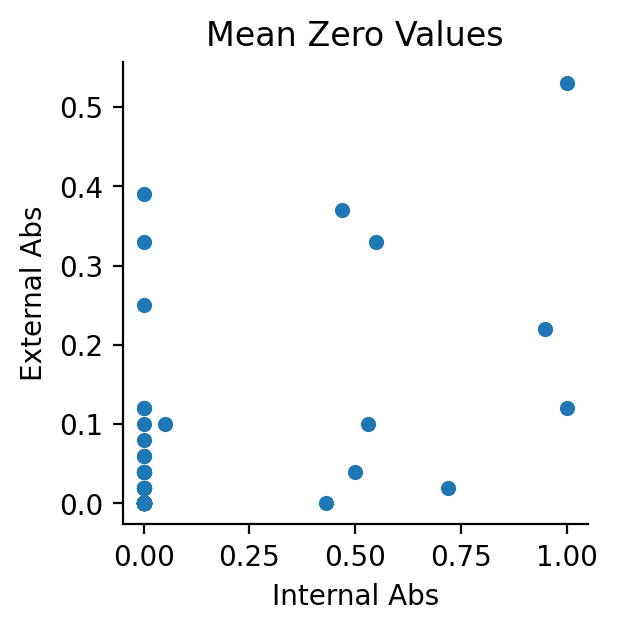

In [5]:
mean_zero1 = (X_train==0).mean()
mean_zero2 = (th_ab_descriptors_df==0).mean()
mean_zero_df = np.round(pd.DataFrame(dict (mean_zero1=mean_zero1, mean_zero2=mean_zero2)),2)
mean_zero_df.plot(x= 'mean_zero1', y='mean_zero2', kind='scatter', title = 'Mean Zero Values', 
                 figsize=(3,3), xlabel = 'Internal Abs', ylabel = 'External Abs')
sns.despine()

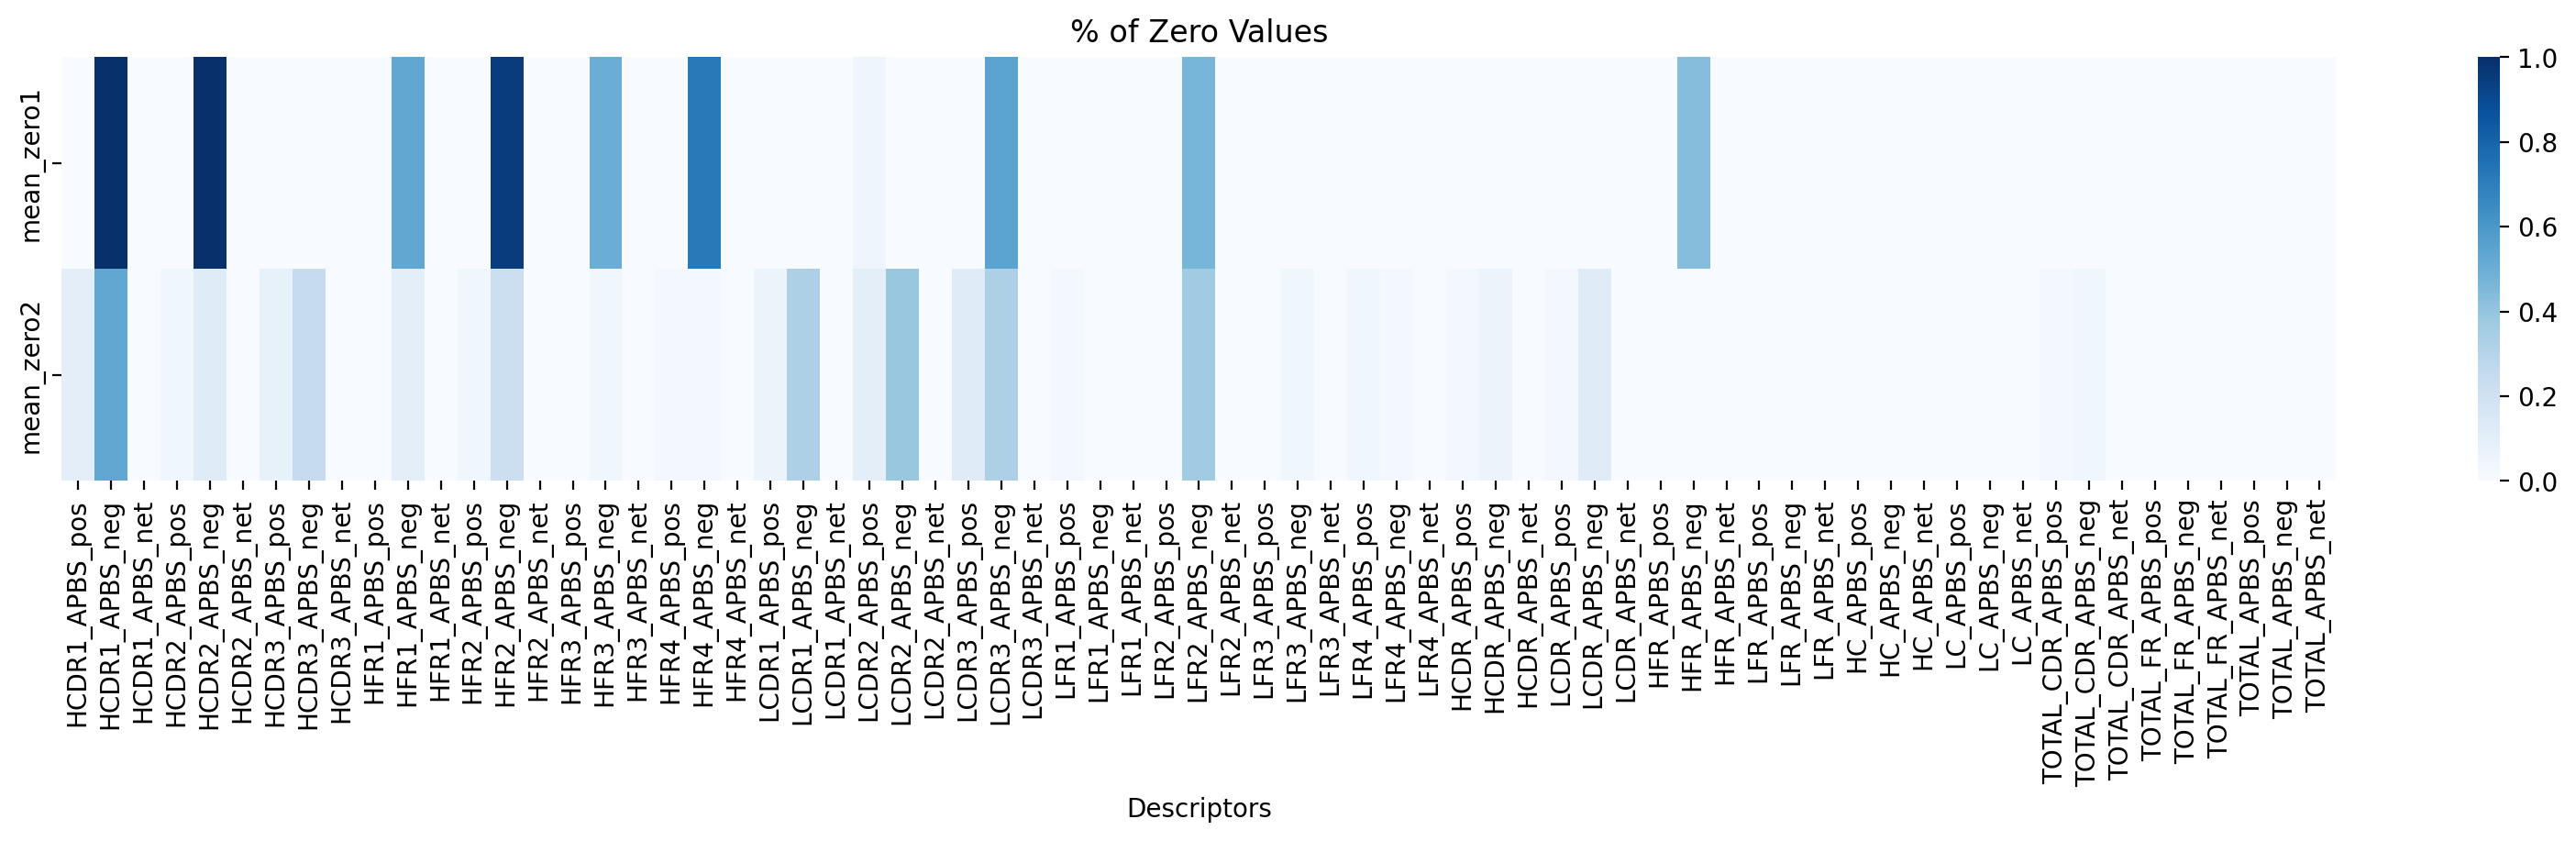

In [6]:
fig, axes = plt.subplots(1,1, figsize = (20, 3))
ax = sns.heatmap(mean_zero_df.T, cmap = 'Blues')
ax.set(title = '% of Zero Values', xlabel = 'Descriptors');

##### Select columns with less than 100% zeros

In [7]:
keep = (mean_zero_df<1).sum(axis = 1)==2
cols = keep.index[keep]
X_train = X_train[cols]
th_ab_descriptors_df = th_ab_descriptors_df[cols]



#### DO PCA and check 

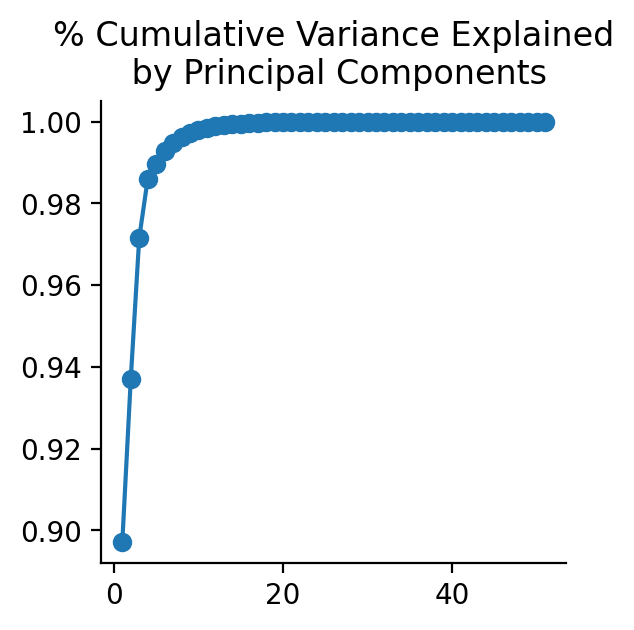

In [10]:


pca = PCA()
pca.fit(th_ab_descriptors_df)

cum_var = pd.Series(np.cumsum(pca.explained_variance_ratio_), index = range(1, len(pca.explained_variance_ratio_)+1))
ax = cum_var.plot(title = '% Cumulative Variance Explained\n by Principal Components', figsize = (3,3), marker = 'o')
sns.despine()



##### Train A PCA
And Use to fit a model. 

In [11]:
pca = PCA(n_components = 10)
pca.fit(th_ab_descriptors_df)


PCA(n_components=10)

##### Train a Lasso regressor using 10 PCAs. 

In [12]:
pipes = Pipeline([('scaler', StandardScaler()), 
                  ('lasso', Lasso())])

X_train_pca = pca.transform(X_train[cols])   # need to select the train

cv =  RepeatedKFold(random_state=42)

search = GridSearchCV(pipes, param_grid = {'lasso__alpha':np.logspace(start =-5, stop = 2)}, cv = cv, refit ='neg_root_mean_squared_error', return_train_score = True,scoring=['neg_root_mean_squared_error','r2'])
search.fit(X_train_pca, y_train[['Hep RTT']])

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.00000000e-05, 1.38949549e-05, 1.93069773e-05, 2.68269580e-05,
       3.72759372e-05, 5.17947468e-05, 7.19685673e-05, 1.00000000e-04,
       1.38949549e-04, 1.93069773e-04, 2.68269580e-04, 3.7275...
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02])},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'])

In [13]:
results = (pd.DataFrame(search.cv_results_)
          .sort_values('mean_test_neg_root_mean_squared_error', ascending = False)
           )
        
cols = [col for col in results.columns if col.startswith('mean') or col.startswith('param') or 'rank' in col]
results[cols].head()

,mean_fit_time,mean_score_time,param_lasso__alpha,params,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,mean_test_r2,rank_test_r2,mean_train_r2
12,0.000757,0.000643,0.000518,{'lasso__alpha': 0.0005179474679231213},-0.021794,1,-0.018099,0.777338,1,0.885204
13,0.000748,0.000635,0.00072,{'lasso__alpha': 0.0007196856730011514},-0.021826,2,-0.018306,0.775786,2,0.882651
11,0.000795,0.000639,0.000373,{'lasso__alpha': 0.0003727593720314938},-0.021941,3,-0.017870,0.774835,3,0.887969
14,0.000740,0.000642,0.001,{'lasso__alpha': 0.001},-0.022063,4,-0.018612,0.770142,4,0.878719
10,0.000888,0.000640,0.000268,{'lasso__alpha': 0.00026826957952797245},-0.022304,5,-0.017555,0.767941,5,0.891827


In [14]:
def organize_search_results(results, param):
    """ organize grid search results into long format"""

    def format_subset(dataset): 
        cols = [col for col in results.columns if 'split' in col and dataset in col]
        col_dict = {}
        for col in cols: 
            metric = col.split(f'{dataset}_')[1]
            col_dict.setdefault(metric,[])
            col_dict[metric].append(col)

        dfs = []
        for metric, cols in col_dict.items():
            
            df = (results.melt(id_vars = param, value_vars=cols)
                  .drop('variable', axis = 1)
                  .rename({'value': metric}, axis = 1)
                  .set_index(param)
            )
            dfs.append(df)
        df= pd.concat(dfs,axis = 1)
        df.insert(0,'dataset', dataset)
        return df

    test_df = format_subset('test')
    train_df = format_subset('train')
    return (pd.concat([test_df, train_df])
            .reset_index()
            .sort_values(['dataset', param])
            )     

In [15]:
long_scores_df= organize_search_results(results, 'param_lasso__alpha')
long_scores_df.head()

,param_lasso__alpha,dataset,neg_root_mean_squared_error,r2
15,0.00001,test,-0.029491,0.596696
65,0.00001,test,-0.013804,0.918563
115,0.00001,test,-0.029677,0.686232
165,0.00001,test,-0.032421,0.589865
215,0.00001,test,-0.015373,0.940811


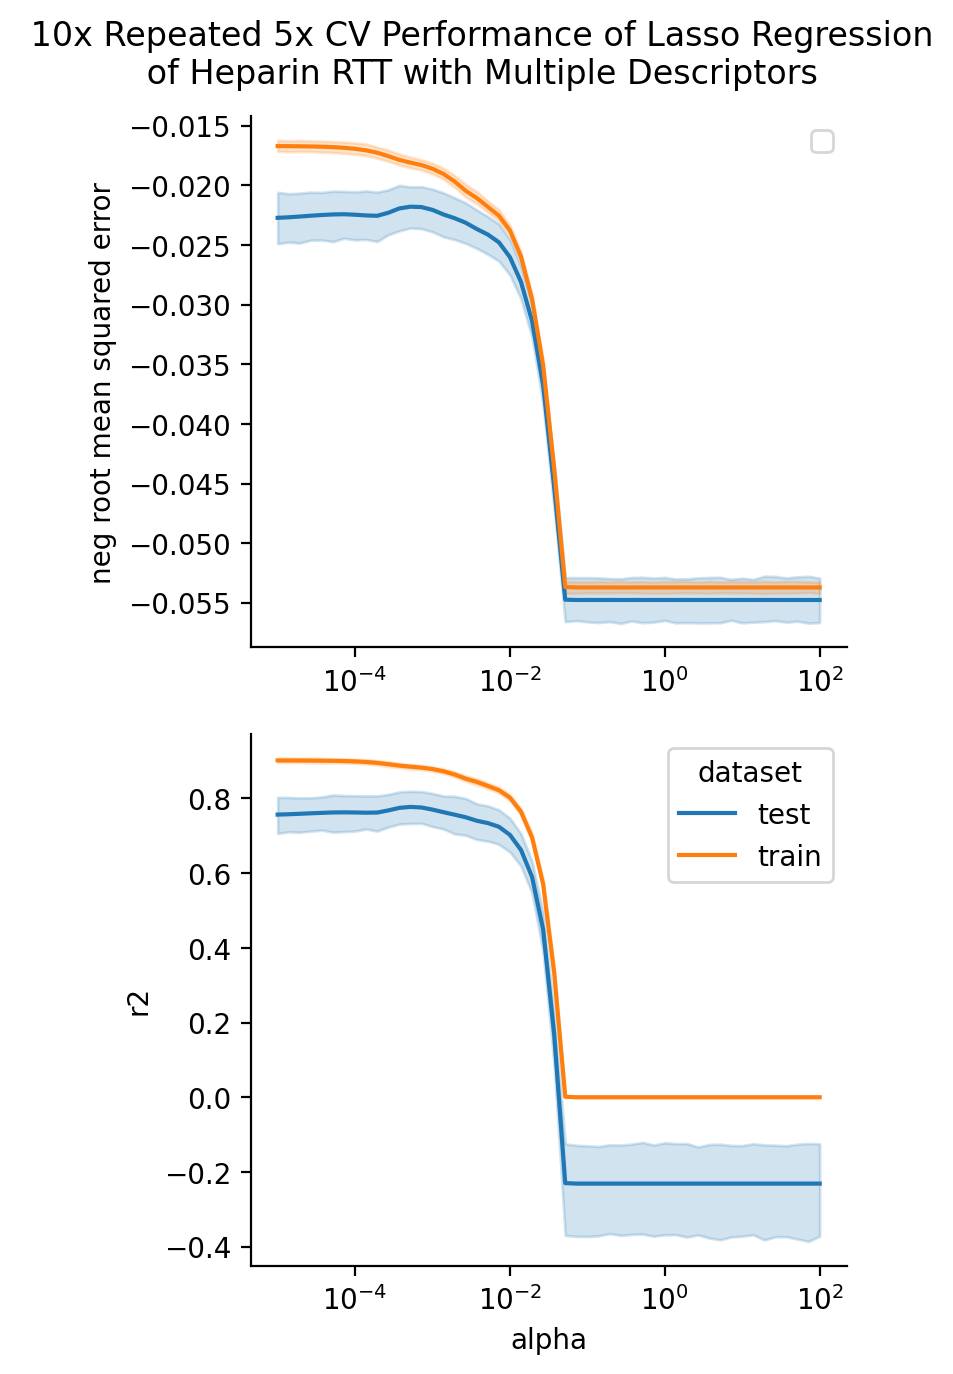

In [16]:

fig, axes = plt.subplots(2,1, figsize = (4,7))
axes = np.ravel( axes)
ax = sns.lineplot(data = long_scores_df, x='param_lasso__alpha', y= 'neg_root_mean_squared_error', hue = 'dataset', ax =axes[0])
ax.set(xscale='log', xlabel = '',ylabel = 'neg_root_mean_squared_error'.replace('_', ' '))
ax.legend('')

ax = sns.lineplot(data = long_scores_df, x='param_lasso__alpha', y= 'r2', hue = 'dataset', ax = axes[1])
ax.set(xscale='log', xlabel = 'alpha')
fig.suptitle(' 10x Repeated 5x CV Performance of Lasso Regression\n of Heparin RTT with Multiple Descriptors')
sns.despine()
fig.tight_layout()

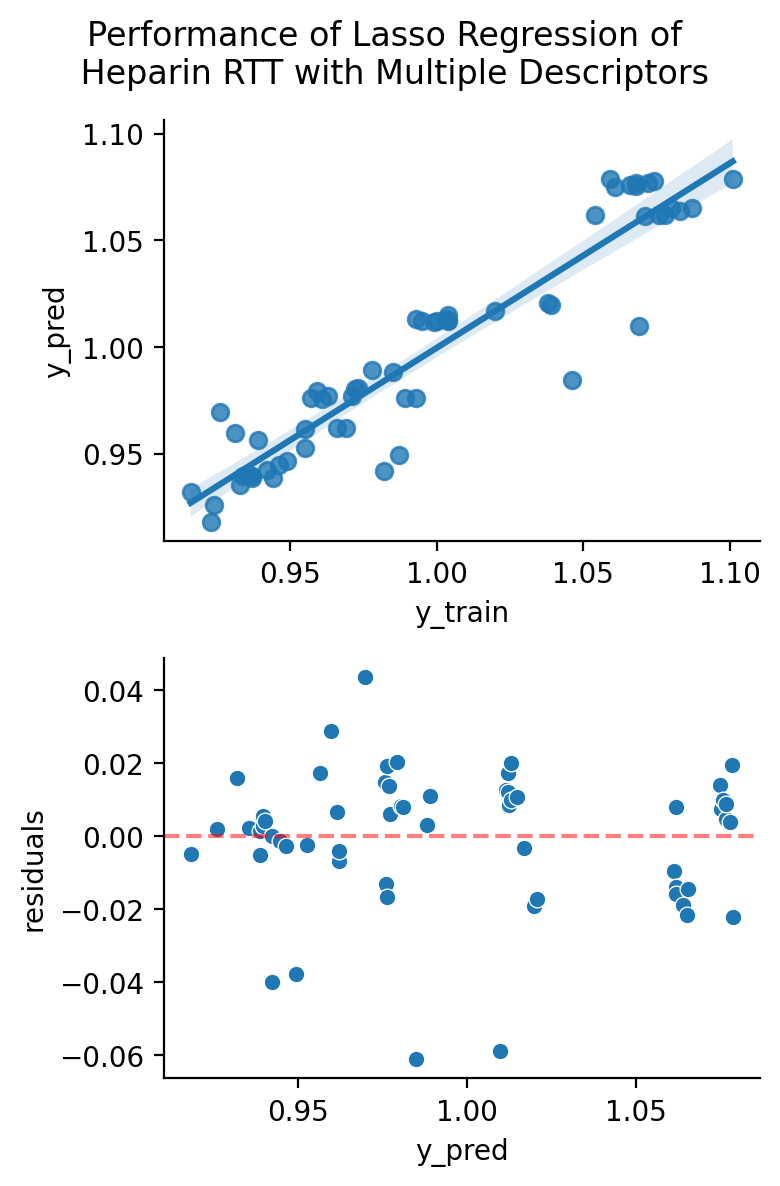

In [17]:
y_pred = search.predict(X_train_pca)
resid = (y_pred - y_train['Hep RTT']).values
y_vals = (pd.DataFrame(dict( y_train = y_train['Hep RTT'], y_pred =y_pred, resid = resid))
          .sort_values('y_pred'))
y_vals.head()

fig, axes = plt.subplots(2,1, figsize = (4,6))
axes = np.ravel(axes)

ax = sns.regplot(data = y_vals, x='y_train', y = 'y_pred', ax = axes[0])
ax.set(ylabel='y_pred')

sns.scatterplot(data = y_vals, x='y_pred', y = 'resid', ax = axes[1])
ax = plt.gca()
ax.axhline(0, color = 'red', linestyle = '--', alpha = 0.5)
ax.set(xlabel = 'y_pred', ylabel= 'residuals')

sns.despine()
fig.suptitle('Performance of Lasso Regression of \n Heparin RTT with Multiple Descriptors')
fig.tight_layout()

#### Train a Logistic Regression Model using PCA components. 

In [18]:
pipes = Pipeline([('scaler', StandardScaler()), 
                  ('logistic', LogisticRegression(penalty='l1', solver = 'liblinear'))])

metrics = ['accuracy', 'recall', 'f1', 'roc_auc']

y = y_train[['Label']].values.reshape(len(y_train), )
cv = RepeatedStratifiedKFold(random_state=42)
search2 = GridSearchCV(pipes, param_grid = {'logistic__C':np.logspace(start =-5, stop = 2)}, cv = cv, refit ='roc_auc', return_train_score = True,scoring=metrics, n_jobs=-1)
search2.fit(X_train_pca,y )

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.00000000e-05, 1.38949549e-05, 1.93069773e-05, 2.68269580e-05,
       3.72759372e-05, 5.17947468e-05, 7.19685673e-05,...
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02])},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'recall', 'f1', 'roc_auc'])

In [19]:
results = pd.DataFrame(search2.cv_results_).sort_values('mean_test_roc_auc', ascending = False)
cols = [col for col in results.columns if col.startswith('mean') or col.startswith('param') or 'rank' in col]
results[cols].head()


,mean_fit_time,mean_score_time,param_logistic__C,params,mean_test_accuracy,rank_test_accuracy,mean_train_accuracy,mean_test_recall,rank_test_recall,mean_train_recall,mean_test_f1,rank_test_f1,mean_train_f1,mean_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc
45,0.000896,0.002010,26.826958,{'logistic__C': 26.82695795279722},0.848333,23,0.962083,0.795,22,0.970842,0.798535,23,0.953379,0.968304,1,0.995984
46,0.001698,0.002181,37.275937,{'logistic__C': 37.27593720314938},0.853333,22,0.970000,0.793,23,0.974895,0.805795,22,0.962788,0.967161,2,0.996815
44,0.000858,0.002461,19.306977,{'logistic__C': 19.306977288832496},0.858333,20,0.954167,0.817,19,0.966632,0.813274,20,0.943854,0.966643,3,0.994788
29,0.000545,0.002310,0.13895,{'logistic__C': 0.1389495494373136},0.910000,3,0.915000,0.960,1,0.958421,0.898962,3,0.900516,0.964357,4,0.964518
31,0.000606,0.002307,0.26827,{'logistic__C': 0.2682695795279722},0.900000,5,0.913333,0.960,1,0.958421,0.889743,6,0.898834,0.964304,5,0.968133


{'lasso__alpha': 0.0005179474679231213}


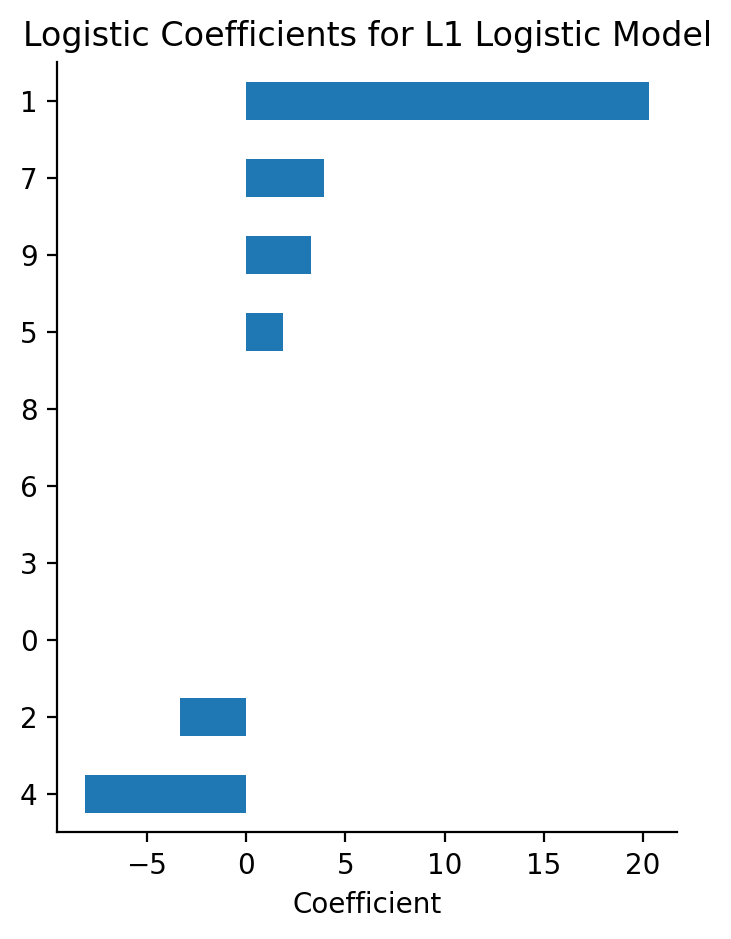

In [20]:
print(search.best_params_)
logistic = search2.best_estimator_
coefs = pd.Series(logistic.steps[1][1].coef_[0])
ax = coefs.sort_values().plot(kind = 'barh', figsize = (4,5))
ax.set(xlabel = 'Coefficient', title='Logistic Coefficients for L1 Logistic Model')
sns.despine()

#### Remarks: 
Doing PCA on the external data, seemed to have little effect for classication, but made regression worse. 
This is something that I can explore more later. 


#### Now try Semi Supervised learning. 
In this experiment, We are using the SelfTrainingClassifier Class.
It is based on Yarowskies Algorithm. It first trains a classifer on the labeled data. It then predicts the class of the unlabeled. It then trains using all the labels. Then relabels. It does this over several iterations. 


##### Combine the external data with the training data. 

In [21]:
X_combined = pd.concat([X_train, th_ab_descriptors_df]).reset_index(drop=True)
y_combined = pd.concat([y_train['Label'], pd.Series([-1]*len(th_ab_descriptors_df))]).reset_index(drop=True)
y_combined

0       1
1       1
2       0
3       0
4       1
5       0
6       0
7       0
8       0
9       1
10      1
11      1
12      1
13      0
14      0
15      1
16      0
17      0
18      0
19      1
20      1
21      0
22      0
23      1
24      0
25      1
26      0
27      0
28      0
29      1
30      1
31      0
32      1
33      1
34      0
35      0
36      1
37      0
38      1
39      0
40      0
41      1
42      0
43      1
44      0
45      0
46      1
47      0
48      1
49      0
50      0
51      1
52      0
53      0
54      0
55      0
56      0
57      1
58      0
59      0
60     -1
61     -1
62     -1
63     -1
64     -1
65     -1
66     -1
67     -1
68     -1
69     -1
70     -1
71     -1
72     -1
73     -1
74     -1
75     -1
76     -1
77     -1
78     -1
79     -1
80     -1
81     -1
82     -1
83     -1
84     -1
85     -1
86     -1
87     -1
88     -1
89     -1
90     -1
91     -1
92     -1
93     -1
94     -1
95     -1
96     -1
97     -1
98     -1
99     -1


In [22]:
def cross_validate_semi_supervised_logistic(c=0.01):
    metrics = ['accuracy']


    cv = RepeatedStratifiedKFold(random_state=42) 
    logistic = LogisticRegression(C=c, penalty='l1', solver = 'liblinear', multi_class='auto')

    pipes = Pipeline([('scaler', StandardScaler()), 
                    ('semi_sup', SelfTrainingClassifier(logistic) )
                    ])
    x = X_combined
    y = y_combined.astype(int)

    scores = cross_validate(pipes, X=x, y=y, cv=cv, scoring=metrics, return_train_score=True)
    
    
    scores = pd.DataFrame.from_dict(scores)
    scores.index= [c]*len(scores)
    
    return scores



In [23]:
scores_df = []
for c in np.logspace(start =-2, stop = 6):
    scores = cross_validate_semi_supervised_logistic(c)
    scores_df.append(scores)

scores_df = pd.concat(scores_df).reset_index().rename({'index':'C'}, axis = 1)

In [24]:

scores_df

,C,fit_time,score_time,test_accuracy,train_accuracy
0,0.01,0.002586,0.001181,0.304348,0.329545
1,0.01,0.001865,0.000634,0.318182,0.325843
2,0.01,0.002505,0.000668,0.318182,0.325843
3,0.01,0.012724,0.003226,0.318182,0.325843
4,0.01,0.005225,0.000772,0.363636,0.314607
...,...,...,...,...,...
2495,1000000.00,0.532988,0.000880,0.391304,0.545455
2496,1000000.00,0.517803,0.000815,0.454545,0.539326
2497,1000000.00,0.010825,0.000620,0.409091,0.539326
2498,1000000.00,0.509902,0.000868,0.545455,0.539326


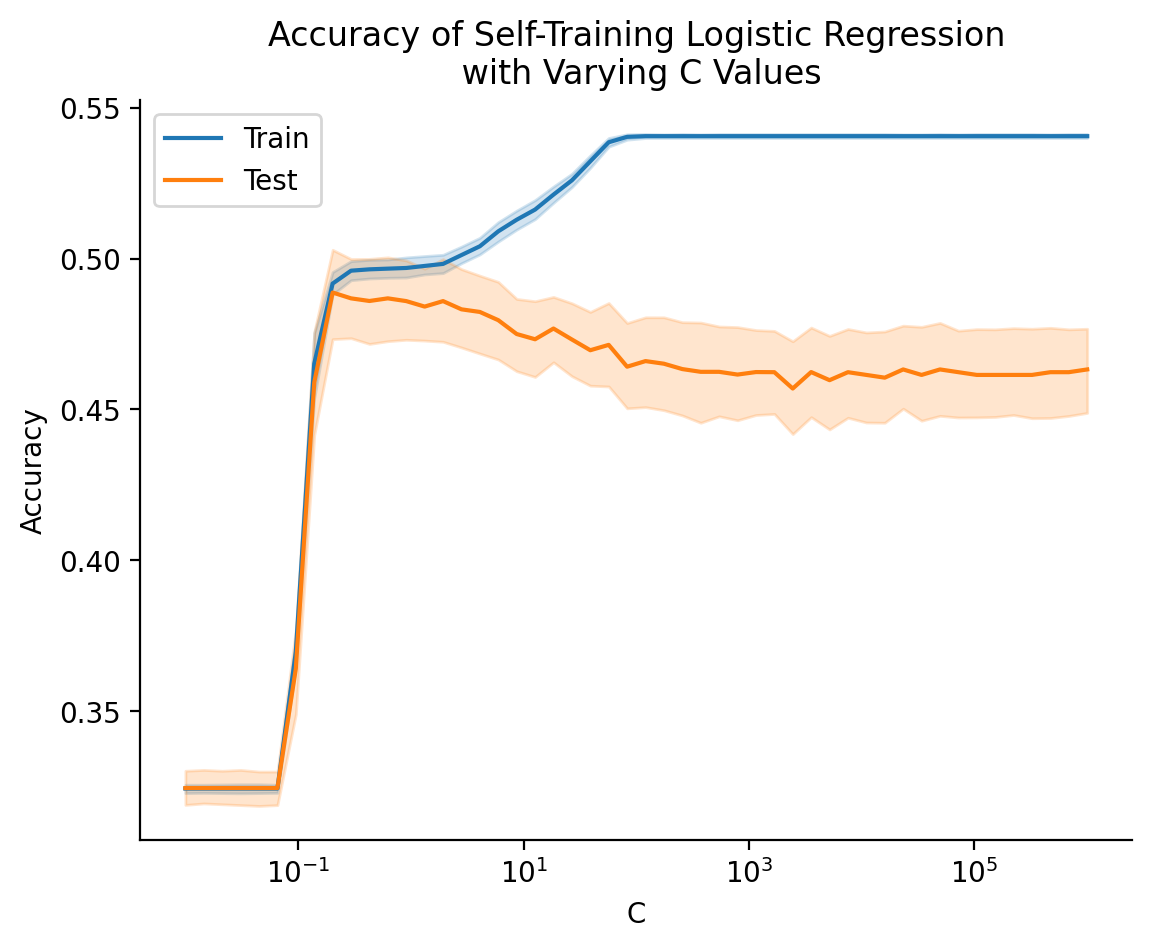

In [25]:
ax= sns.lineplot(data = scores_df, x='C', y = 'train_accuracy', label = 'Train')
sns.lineplot(data = scores_df, x='C', y = 'test_accuracy', label = 'Test')
ax.set(title = 'Accuracy of Self-Training Logistic Regression\n with Varying C Values', xscale='log', ylabel='Accuracy', xlabel = 'C');
sns.despine()

### Remarks: 

Neither PCA or SelfTrainingClassifier led to improvement in performance.